#INSTALADORES

In [1]:
!pip install tensorboard
!pip install torchinfo
!pip install --upgrade torch torchvision

#GOOGLE DRIVE

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
! cp "/content/drive/MyDrive/Colab Notebooks/MLP/data.csv" /content
! cp "/content/drive/MyDrive/Colab Notebooks/MLP/img.zip" /content
! unzip -q img.zip
! rm img.zip

#Weights and Biases INICIALIZACION

In [4]:
!pip install wandb
!wandb login

#59faca4190d33815ba5b1ce0a93431b26067d3a8

import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=0878ee8428f60d158070ad3625269489e86f8ebb7465ecc24f3195888d7dd7e2
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#FUNCIONES BASE ENTRENO

In [198]:
import time
import datetime
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.utils.tensorboard import SummaryWriter
import torchinfo
import numpy as np
import random
import pandas as pd
import csv
from PIL import Image
import os

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [199]:
def train_step(mlp_model, criterion, optim, img,tabulars, label, batch_size, numberOfClass):
    optim.zero_grad()
    output = mlp_model(img, tabulars)
    loss = criterion(output, label)
    loss.backward()
    optim.step()
    step_loss = loss.item()
    return step_loss

def train_epoch(mlp_model, loader, criterion, optim,mb,numberOfClass):
    epoch_loss_accumulated = 0.0
    for img, tabulars, labels in  progress_bar(loader,parent = mb):
      batch_size = img.size(0)
      epoch_loss_accumulated += train_step(mlp_model,criterion,optim, img.to(device), tabulars.to(device), labels.to(device), batch_size,numberOfClass)
    return epoch_loss_accumulated/len(loader)

In [200]:
def validation_epoch(mlp_model, val_loader, criterion, classes = None):
    mlp_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
      for images, tabulars, labels in val_loader:
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        tabulars = tabulars.to(device)
        labels = labels.to(device)
        predictions = mlp_model(images.to(device), tabulars)
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())
        loss = criterion(predictions, labels)

        epoch_loss += loss.item()

    return epoch_loss / len(val_loader), accuracy_score(all_labels, all_predictions) * 100

In [201]:
def train_model(mlp_model, train_loader, valid_loader, criterion, optim, number_epochs,numberOfClass):
  train_history = []
  valid_history = []
  accuracy_history = []
  now = datetime.datetime.now()
  date_time = now.strftime("%m%d%Y_%H%M%S")
  name = 'runs/'+mlp_model.name+'_'+date_time
  tensorBoard_writer = SummaryWriter(name)
  mb = master_bar(range(1, number_epochs+1))
  for epoch in mb:
      start_time = time.time()
      train_loss = train_epoch(mlp_model, train_loader, criterion, optim,mb,numberOfClass)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, time.time() - start_time))

      start_time = time.time()
      val_loss, acc = validation_epoch(mlp_model, valid_loader, criterion)
      valid_history.append(val_loss)
      accuracy_history.append(acc)
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, val_loss, acc, time.time() - start_time))
      # Se carga en tensorBoard #Loss #Validation en train y val
      wandb.log({"Train Loss": train_loss})
      wandb.log({"Validation Loss": val_loss})
      wandb.log({"Accuracy": acc})

      tensorBoard_writer.add_scalar(tag="Train Loss", scalar_value=train_loss, global_step=epoch)
      tensorBoard_writer.add_scalar(tag="Validation Loss", scalar_value=val_loss, global_step=epoch)
      tensorBoard_writer.add_scalar(tag="Validation Accuracy", scalar_value=acc, global_step=epoch)
  tensorBoard_writer.close()

#CARGA DE DATOS

In [202]:
# Creamos los dataloaders
val_transform = transforms.Compose([
    transforms.Resize([256,192]),
])

train_transform = transforms.Compose([
    transforms.Resize([256,192]),
    transforms.RandomRotation(degrees=(0,45)),
    transforms.ColorJitter(hue=(-0.05,0.05))
])

In [203]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import os

class MLP_Dataset(Dataset):
    def __init__(self, image_dir='./img/', data_dir='./data.csv', transform=None):
        self.image_dir = image_dir
        self.data_dir = data_dir

        self.transform = transform

        self.tabular_data = self.openDataFile()
        arr = np.array(self.tabular_data)
        print(arr.shape)

        self.tabular_data = list(filter(self.hasImage, self.tabular_data))
        self.labels = torch.tensor(list(map(self.targetToClass, self.tabular_data)))

        #image file is not to be changed to numpy
        self.image_files = [str(row[0]) for row in self.tabular_data]
        self.tabular_data = torch.tensor(np.array(self.tabular_data)[:,1:6])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = torchvision.io.read_image(img_path)

        tabular_data = self.tabular_data[idx]
        label = self.labels[idx]

        if self.transform:
          image = self.transform(image)

        return image,tabular_data, label

    def hasImage(self, line):
      image_path = os.path.join(self.image_dir + str(line[0]))
      return os.path.isfile(image_path)

    def targetToClass(self, line):
        label = [1.0,0.0,0.0,0.0]
        if line[6] > 100000 and line[6] <= 200000:
          label = [0.0,1.0,0.0,0.0]
        elif line[6] > 200000 and line[6] <= 300000:
          label = [0.0,0.0,1.0,0.0]
        elif line[6] > 300000:
          label = [0.0,0.0,0.0,1.0]
        return label

    def openDataFile(self):
      tabular_data = []
      with open(self.data_dir, 'r') as file:
        lector_csv = csv.reader(file)
        next(lector_csv)
        for fila in lector_csv:
          fila_enteros = [int(float(valor)) for valor in fila]
          tabular_data.append(fila_enteros)
      return tabular_data


In [204]:
def get_dataloaders(batch_size = 32, data_dir = './data.csv', image_dir = './img/', t_transform=train_transform, v_transform=val_transform, augment_data=False):
# Vector de vectores img, tabulares, label -------------------------------------------------------------------------------------------------------------------------------------
  dataset = MLP_Dataset(image_dir, data_dir, transform=None)
  #dataset = MLP_Dataset(image_dir='/Users/joaquinoldan/Documents/MASTER AI/3- Machine Learning en Producción/Obligatorio/MLOps/modelos/img/', data_dir='/Users/joaquinoldan/Documents/MASTER AI/3- Machine Learning en Producción/Obligatorio/MLOps/modelos/data.csv')
# Vector de vectores img, tabulares, label -------------------------------------------------------------------------------------------------------------------------------------

  BATCH_SIZE = batch_size

  # Separamos en train y validation
  train_size = int(0.8 * len(dataset))
  valid_size = len(dataset) - train_size

  train, validation = torch.utils.data.random_split(dataset, [train_size,valid_size])

  if(augment_data):
    dataset_train = MLP_Dataset(image_dir, data_dir, transform=t_transform)
    dataset_val = MLP_Dataset(image_dir, data_dir, transform=v_transform)
    train.dataset = dataset_train
    validation.dataset = dataset_val


  print(f"{len(train)} Training Items, {len(validation)} Validation Items")

  # Podemos usar data loaders como vimos en el práctico.
  train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)
  valid_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)

  return train_loader, valid_loader

### Test Dataloaders

In [193]:
train_loader, val_loader = get_dataloaders(batch_size=32, t_transform=train_transform, v_transform=val_transform, augment_data=False)

(25099, 7)
19981 Training Items, 4996 Validation Items


In [194]:
dataiter1 = iter(train_loader)
dataiter2 = iter(val_loader)

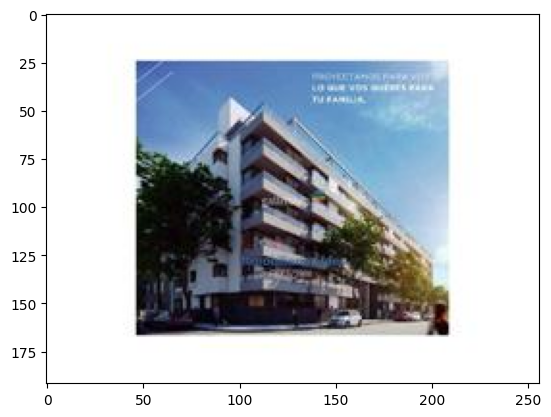

In [195]:
image1 = next(dataiter1)
plt.imshow(image1[0][0].permute(1, 2, 0))

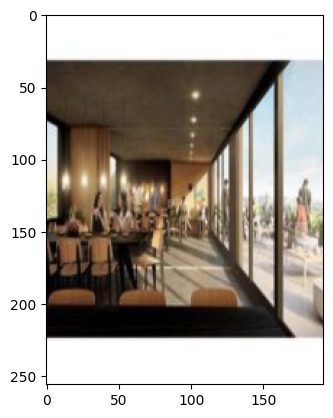

In [192]:
image2 = next(dataiter2)
plt.imshow(image2[0][0].permute(1, 2, 0))

#MODELO

In [205]:
class MLP_Model(nn.Module):
  def __init__(self,name="MLP_MODEL", vocab_size=260, embedding_dim=4, num_classes=4):
    super().__init__()
    self.name = name
    self.embedding = nn.Embedding(num_embeddings=vocab_size,embedding_dim=embedding_dim)
    # Input -> 256*192
    self.conv1 = nn.Conv2d(3, 128, 4, stride=2, padding=1, bias=False)
    # 256*192 -> conv1(1/2) -> 128*96
    self.bn1 = nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False)
    # 128*96 -> conv1(1/2) -> 64*48
    self.bn2 = nn.BatchNorm2d(256)
    self.conv3 = nn.Conv2d(256, 128, 4, stride=2, padding=1, bias=False)
    # 64*48 -> conv1(1/2) -> 32*24
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 32, 4, stride=2, padding=1, bias=False)
    # 32*24 -> conv1(1/2) -> 16*12
    self.bn4 = nn.BatchNorm2d(32)
    self.conv5 = nn.Conv2d(32, 8, 4, stride=2, padding=1, bias=False)
    # 16*12 -> conv1(1/2) -> 8*6
    self.bn5 = nn.BatchNorm2d(8)
    self.conv6 = nn.Conv2d(8, 1, 4, stride=2, padding=1, bias=False)
    # 8*6 -> conv1(1/2) -> 4*3
    self.bn6 = nn.BatchNorm2d(1)
    self.linear1 = nn.Linear(1*4*3+5+(embedding_dim-1), 1024)
    self.linear2 = nn.Linear(1024, 512)
    self.linear3 = nn.Linear(512, 128)
    self.linear4 = nn.Linear(128, 64)
    self.out = nn.Linear(64, num_classes)


  def forward(self, x,tabulars):
    # entrada de 256*192
    emb_Location = self.embedding(tabulars[:,4])
    # area data scaling
    rescalArea = tabulars[:,0:1] /100.0
    #plt.imshow(x[0])
    x = x.view(x.size(0), 3, 256, 192)
    x = torch.round(x).to(torch.float32)
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = F.relu(self.bn5(self.conv5(x)))
    x = F.relu(self.bn6(self.conv6(x)))
    x = x.view(x.size(0), -1)
    x = torch.concat([x,rescalArea,tabulars[:,1:4], emb_Location], -1)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.relu(self.linear3(x))
    x = F.relu(self.linear4(x))
    x = self.out(x)
    x = F.softmax(x,dim = 1)
    return x

In [206]:
torchinfo.summary(MLP_Model())

Layer (type:depth-idx)                   Param #
MLP_Model                                --
├─Embedding: 1-1                         1,040
├─Conv2d: 1-2                            6,144
├─BatchNorm2d: 1-3                       256
├─Conv2d: 1-4                            524,288
├─BatchNorm2d: 1-5                       512
├─Conv2d: 1-6                            524,288
├─BatchNorm2d: 1-7                       256
├─Conv2d: 1-8                            65,536
├─BatchNorm2d: 1-9                       64
├─Conv2d: 1-10                           4,096
├─BatchNorm2d: 1-11                      16
├─Conv2d: 1-12                           128
├─BatchNorm2d: 1-13                      2
├─Linear: 1-14                           21,504
├─Linear: 1-15                           524,800
├─Linear: 1-16                           65,664
├─Linear: 1-17                           8,256
├─Linear: 1-18                           260
Total params: 1,747,110
Trainable params: 1,747,110
Non-trainable params

#PARAMETROS

In [211]:
config = {
    "LR": 2e-4,
    "epochs": 5,
    "batch_size": 32,
    "B": [0.5,0.999],
    "info" : 'Modelo MLP'
}

wandb.init(project="MLP-Obligatorio", entity="vainilla")

config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs

config.learning_rate = 2e-4
config.epochs = 10
config.batch_size = 32
config.B = [0.5,0.999]
config.info = 'Modelo MLP'

In [212]:
# Definimos el modelo y el optimizador
LR = config.learning_rate
epochs = config.epochs
batch_size = config.batch_size
B = config.B

#ENTRENAMIENTO

In [213]:
# Creamos el loaders
train_loader, val_loader = get_dataloaders(batch_size=32, t_transform=train_transform, v_transform=val_transform, augment_data=False)

(25099, 7)
19981 Training Items, 4996 Validation Items


In [214]:
mlp_model = MLP_Model("MLP MODEL", vocab_size=260, embedding_dim=4, num_classes=4).to(device)
opt = torch.optim.Adam(mlp_model.parameters(), lr=LR,betas=B)

weights = torch.tensor([0.31, 0.07, 0.31, 0.31]).to(device)

crit = nn.CrossEntropyLoss(weight=weights)

wandb.watch(mlp_model, log_freq=100)


[]

In [215]:
train_model(mlp_model, train_loader, val_loader, crit, opt, epochs, 4)

Training epoch 2 | Loss 0.183782 | Time 106.19 seconds
Validation epoch 2 | Loss 0.181453 | Accuracy 67.93% | Time 7.97 seconds
Training epoch 3 | Loss 0.172134 | Time 93.35 seconds
Validation epoch 3 | Loss 0.172832 | Accuracy 71.88% | Time 8.07 seconds
Training epoch 4 | Loss 0.168937 | Time 93.06 seconds
Validation epoch 4 | Loss 0.170368 | Accuracy 70.12% | Time 8.08 seconds
Training epoch 5 | Loss 0.166215 | Time 92.78 seconds
Validation epoch 5 | Loss 0.175139 | Accuracy 63.35% | Time 8.02 seconds
Training epoch 6 | Loss 0.164730 | Time 92.77 seconds
Validation epoch 6 | Loss 0.166931 | Accuracy 69.34% | Time 7.62 seconds
Training epoch 7 | Loss 0.163583 | Time 92.62 seconds
Validation epoch 7 | Loss 0.168926 | Accuracy 65.21% | Time 7.47 seconds
Training epoch 8 | Loss 0.162673 | Time 92.59 seconds
Validation epoch 8 | Loss 0.167497 | Accuracy 70.02% | Time 7.76 seconds
Training epoch 9 | Loss 0.162004 | Time 92.44 seconds
Validation epoch 9 | Loss 0.165043 | Accuracy 71.76% | T

In [ ]:
# Guardado del modelo

torch.save(mlp_model.state_dict(),mlp_model.name+".dat")

In [ ]:
%tensorboard --logdir=runs/MLP MODEL_06162023_164609